# Predict Nighttime Light Intensities from Daytime Light 

Current Goal: Use CNN to extract features from daytime lights (Landsat) data and predict levels of nighhtime light intensities (VIIRS).
***
General Steps:
1. Import the data
2. Feature Creation
3. Build the Neural Net
4. Fit and Evaluate the Neural Net
5. Extract Features

In [203]:
import os
import pandas as pd
import geopandas as gpd
import rasterio

import getpass

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten

# Turn off big pink warnings
import warnings
warnings.filterwarnings('ignore')

# Display options 
pd.options.display.max_columns = 8000
pd.options.display.max_colwidth = -1

# Set directory
os.chdir("/Users/nguyenluong/wb_internship/Data/satellite_raw")

In [4]:
# Rob's code
if getpass.getuser() == 'robmarty':
    project_file_path = '/Users/robmarty/Dropbox/World Bank/IEs/Pakistan Poverty Estimation from Satellites'
    
filepath_night = project_file_path + "/Data/VIIRS/RawData/VIIRS Annual/pak_viirs_median_2012.tif"
data_night = rasterio.open(filepath_night)
array_night = data_night.read()
np.nanmean(array_night)

array_night_flat = array_night.flatten()
array_night_flat_nona = array_night_flat[ ~np.isnan(array_night_flat) ]
plt.hist(array_night_flat_nona)

# 1. Import and Prep Data

## 1a. Load and Prep Nighttime Lights Data 

### Load VIIRS Geojson

In [2]:
# Load nighttime VIIRS data (geojson)
viirs_gdf = gpd.read_file('VIIRS/viirs_annual_polygon.geojson')
viirs_gdf.head(2)

,median_rad_2012,median_rad_2013,median_rad_2014,median_rad_2015,median_rad_2016,median_rad_2017,median_rad_2018,id,tile_id,geometry
0,0.121902,0.217595,0.179258,0.213304,0.148595,0.352908,0.34,1,42.0,"POLYGON ((74.66347 37.06224, 74.67021 37.06224..."
1,0.204110,0.223363,0.207353,0.283295,0.156230,0.375000,0.36,2,42.0,"POLYGON ((74.67021 37.06224, 74.67695 37.06224..."


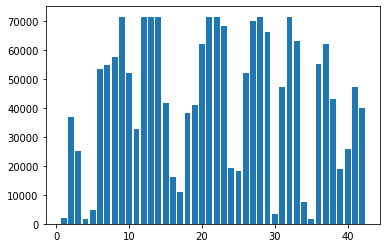

In [235]:
# Distribution of observations by tile_id
tile_counts = viirs_gdf.tile_id.value_counts(dropna=False)
plt.bar(x=tile_counts.index, height=tile_counts);

In [3]:
# Inspecting VIIRS geojson
print('Total number of obs: {}'.format(len(viirs_gdf)))

nan_tile = viirs_gdf[np.isnan(viirs_gdf['tile_id'])]
print('Number of obs with NaN for tile_id: {}'.format(len(nan_tile)))

Total number of obs: 1814237
Number of obs with NaN for tile_id: 1350


### Transform nighttime lights

Transform to lessen heavily skewed distribution. For now, **limit to only 2014 data**.   
***
Options tried here:
- natural log
- square root
- box-cox

In [4]:
from sklearn.preprocessing import power_transform

# Do log(x + 1) to have fully defined domain since data has x = 0
viirs_gdf['log_median_rad_2014'] = np.log(viirs_gdf['median_rad_2014'] + 1)
log_rad = np.log(viirs_gdf['median_rad_2014'] + 1).to_numpy()

sqrt_rad = np.sqrt(viirs_gdf['median_rad_2014']).to_numpy()

# Do box-cox with (x + 1) because needs strictly positive values 
bc_rad = power_transform((viirs_gdf['median_rad_2014'] + 1).to_numpy().reshape(-1, 1), method='box-cox')

Explore the distributions of variable transformations to decide which to go forward with.

Summary of log
DescribeResult(nobs=1814237, minmax=(0.0, 7.003241113635235), mean=0.20576721970884848, variance=0.062333206493509284, skewness=6.602233458742071, kurtosis=63.58599491384153)

Summary of square-root
DescribeResult(nobs=1814237, minmax=(0.0, 33.154083267445166), mean=0.45985096480354326, variance=0.10546258282824325, skewness=10.262868875497135, kurtosis=252.55956265564947)

Summary of box-cox
DescribeResult(nobs=1814237, minmax=(-3.0815043715438386, 2.3062005044008833), mean=8.316728796961411e-16, variance=1.0000005511962058, skewness=0.5906939197104081, kurtosis=-0.34560818439899155)



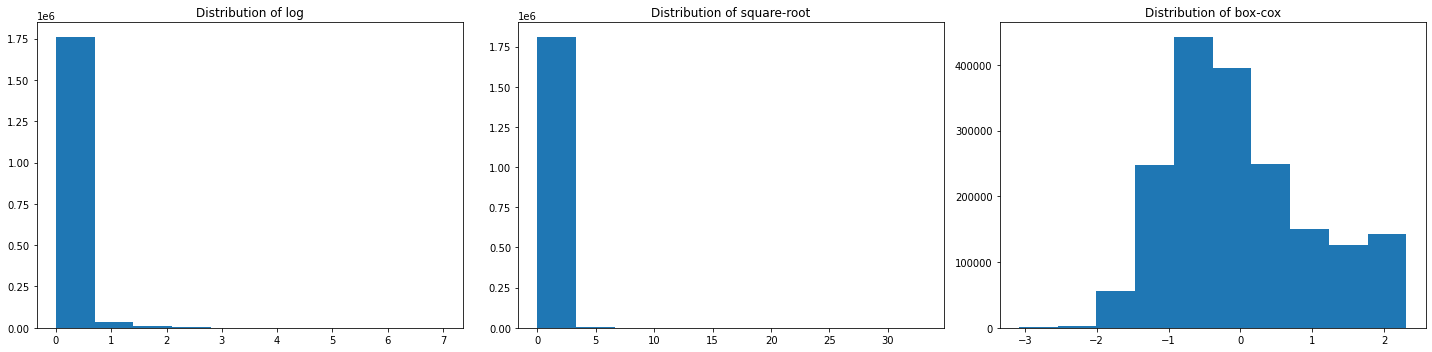

In [5]:
from scipy import stats

def explore_distrib(vars_dict):
    '''
    Generates descriptive statististics and plots distribution of variables.
    
    Inputs:
        vars_dict (dict) keys are variable names, values are np.ndarrays representing variables
    Returns:
        None
    '''
    fig, ax = plt.subplots(figsize=(20,5), ncols=len(vars_dict.values()))
    i = 0
    for var_name, array in vars_dict.items():
        if len(array.shape) > 1:
            array = array.flatten()
        print('Summary of ' + var_name)
        print(stats.describe(array))
        print()
        ax[i].hist(array);
        ax[i].set_title('Distribution of ' + var_name);
        i += 1
    plt.tight_layout()
    plt.show()

vars_dict = {'log': log_rad, 'square-root': sqrt_rad, 'box-cox': bc_rad}
explore_distrib(vars_dict)

### Choose Transformation and Bin NLT

I feel like it makes sense to feel values positive for interpretation of radiance. Log has lowered skewness and smaller range of values. So, I will discretize log median radiance for 2014 with k-means clustering.

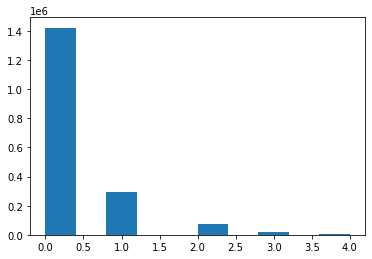

In [6]:
from sklearn.preprocessing import KBinsDiscretizer
# Reshape array to be a column rather than a row
log_rad = viirs_gdf['log_median_rad_2014'].to_numpy().reshape(-1,1)
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
viirs_gdf['log_binned'] = discretizer.fit_transform(log_rad)
plt.hist(viirs_gdf['log_binned']);

In [7]:
# Nighttime lights is bucketed into 5 categories
print('Bins')
print(viirs_gdf['log_binned'].value_counts())
print('Bin edges: {}'.format(discretizer.bin_edges_[0]))

Bins
0.0    1422278
1.0     294299
2.0      72758
3.0      18364
4.0       6538
Name: log_binned, dtype: int64
Bin edges: [0.         0.2270032  0.51066626 1.08064124 2.13831268 7.00324111]


## 1b. Create Random Sample
***
For now, sample for 15 observations for each NTL bin.

In [8]:
def sample_by_NTL(df, NTL_col, n):
    '''
    Create a sample dataframe that contains n observations from each NTL bin.
    
    Inputs:
        df (pandas.DataFrame) NTL dataframe
        NTL_col (str) column name for target variable
        n (int) number of observations per target bin
    Returns:
        rv (pandas.DataFrame)
    '''
    rv = pd.DataFrame()
    for x in df[NTL_col].unique():
        bin_df = df[df[NTL_col] == x]
        sample_df = bin_df.sample(n=n, random_state=1)
        rv = rv.append(sample_df)
    return rv
        
df_2014 = viirs_gdf[['tile_id', 'median_rad_2014', 'log_median_rad_2014', 'log_binned', 'geometry']]
NTL_df = sample_by_NTL(df_2014, 'log_binned', 15)
print(NTL_df['log_binned'].value_counts())
NTL_df.head()

4.0    15
3.0    15
2.0    15
1.0    15
0.0    15
Name: log_binned, dtype: int64


,tile_id,median_rad_2014,log_median_rad_2014,log_binned,geometry
1673685,7.0,0.091575,0.087621,0.0,"POLYGON ((64.69891 25.48745, 64.70565 25.48745..."
859908,21.0,0.122107,0.115208,0.0,"POLYGON ((67.71725 29.73199, 67.72399 29.73199..."
618665,25.0,0.127695,0.120176,0.0,"POLYGON ((66.80771 31.15357, 66.81445 31.15357..."
1002658,22.0,0.196145,0.179104,0.0,"POLYGON ((70.47957 29.11889, 70.48631 29.11889..."
1467539,8.0,0.079857,0.076829,0.0,"POLYGON ((66.90203 26.61259, 66.90877 26.61259..."


In [9]:
# Remove observations with NaN as tile_id
NTL_df = NTL_df[ ~ np.isnan(NTL_df['tile_id'])]
len(NTL_df)

75

## 1c. Get DLT corresponding sampled NTL

In [10]:
from rasterio.mask import mask

def format_coords(Polygon):
    '''
    Format coordinates of a Polygon to what rasterio likes for masking/cropping.
    
    Inputs:
        Polygon (shapely.Polygon object)
    Returns:
        (list of dictionary)
    '''
    coords = list(Polygon.exterior.coords)
    dictionary = {'type': 'Polygon'}
    dictionary['coordinates'] = [[list(tup) for tup in coords]]
    return [dictionary]


def crop(raw_DTL, polygon):
    '''
    Crops DLT according to VIIRS polygon.
    
    Inputs:
        raw_DTL (numpy.ndarray)
        polygon (shapely.Polygon object)
    Returns:
        out_img (numpy.ndarray) croppped DTL array
    '''
    shapes = format_coords(polygon)
    out_img, out_transform = mask(raw_DTL, shapes=shapes, crop=True)
    return out_img

    
def get_DTL(row, directory):
    '''
    For a given VIIRS observation, grab and crop corresponding DLT data.
    
    Inputs:
        row (pandas.Series)
        directory (str) 
    Returns: 
        all_bands: (list) list of 7 arrays, each array is 3D
    '''
    all_bands = []
    bands = [*range(1,8)]
    for b in bands:
        tile = row['tile_id']
        polygon = row['geometry']
        filename = ''.join(['l8_2014_tile', str(int(tile)), '_b', str(b), '.tif'])
        filepath = os.path.join(directory, filename)
        raw_DTL = rasterio.open(filepath)
        cropped_DTL = crop(raw_DTL, polygon)
        all_bands.append(cropped_DTL)
    return all_bands


def create_DLT_array(NTL_df, source='Landsat', year='New_2014'):
    '''
    Gets DTL images, crops them, create arrays representing DLT and NLT to become features and targets respectively.
    
    Inputs:
        NTL_df (pandas.DataFrame)
        source, year (str)
    Returns: 
        DLT: (5D numpy.ndarray)
    '''
    rv = []
    df = NTL_df.copy()
    directory = os.path.join(source, year)
    for index, row in df.iterrows():
        DTL = get_DTL(row, directory)
        rv.append(DTL)
    return np.stack(rv)

In [11]:
# Creating DTL array and defining NTL array
DTL = create_DLT_array(NTL_df)
NTL = NTL_df['log_binned'].to_numpy()

print('DLT shape: {}'.format(DTL.shape))
print('NLT shape: {}'.format(NTL.shape))

DLT shape: (75, 7, 1, 25, 26)
NLT shape: (75,)


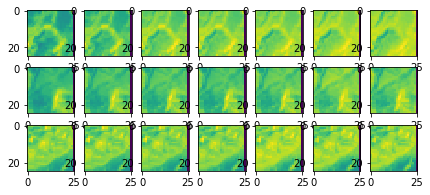

In [12]:
# Plotting bands for a few DTL images as a visual check
to_plot = DTL[0:3]
num_images = to_plot.shape[0]
num_bands = to_plot.shape[1]

f, ax = plt.subplots(figsize=(num_bands, num_images), nrows=num_images, ncols=num_bands)
for i in range(0, num_images):
    for j in range(0, num_bands):
        ax[i, j].imshow(to_plot[i][j][0], origin='upper', interpolation='nearest')

# 2. Reshaping and Normalizing Features and Targets
Reshape the data into an array of 3D tensors and normalize each element.

In [183]:
def prep_dataset(X, Y, height, width, channels):
    '''
    Preps a given dataset for CNN by reshaping features and one-hot encoding targets.
    
    Input:
        X (numpy.ndarray) 5D array of DTL features
        Y (numpy.ndarray) 1D array fo NTL targets
        height, width, channels (int)
    Returns:
        X (numpy.ndarray) 4D array of DTL features
        Y (numpy.ndarray) 2D array of NTL targets
    '''
    # Reshape data to be 4D rather than 5D
    X = X.reshape((X.shape[0], height, width, channels))
    # One-hot encode targets
    Y = to_categorical(Y)
    return X, Y

def normalize(X):
    '''
    Normalizes features.
    
    Inputs:
        X (numpy.ndarray) 4D array of DTL features
    Returns:
        X (numpy.ndarray) 4D array of DTL features
    '''
    # Convert from ints to floats and normalize to 0-1
    return X.astype('float32') / 255.0

# 3. Build the CNN

In [193]:
def define_model(height, width, channels, num_classes):
    '''
    Defines and compiles CNN model.
    
    Inputs:
        height, width, channels, num_classes (int)
    Returns:
        model (keras.Model object)
    '''
    # Define layers
    model = Sequential()
    model.add(Conv2D(filters=64, 
                     kernel_size=(5, 5), 
                     activation='relu', 
                     input_shape=(height, width, channels),
                     name='conv1'))
    model.add(MaxPooling2D(pool_size=(2, 2)), name='maxpool1')
    model.add(Flatten(), name='flatten1')
    model.add(Dense(100, activation='relu', name='dense1'))
    model.add(Dense(num_classes, activation='softmax', name='dense2'))
    
    # Compile model
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    print('Model has been defined. Model summary below.')
    model.summary()
    
    return model

# 4. Fit and Evaluate the CNN

In [194]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False):
    '''
    Plots the confusion matrix, with option to normalize.
    
    Inputs:
        cm (numpy.ndarray) confusion matrix from sklearn
        classes (list) classes/labels for target (NTL)
    Returns:
        None
    '''
    title = 'Confusion Matrix'
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = "Normalized Confusion Matrix"

    # Generate plot
    plt.imshow(cm, interpolation='nearest', cmap='Greens')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    # Format text
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def evaluate_model(model, trainX, trainY, testX, testY):
    '''
    Fits and evaluates model.
    
    Inputs:
        model (CNN model) keras.Model object
        trainX, trainY (numpy.ndarray) 4D array of DTL features and 2D array of targets for training
        testX, testY (numpy.ndarray) 4D array of DTL features and 2D array of targets for training
    Returns:
        None
    '''
    # Fit model
    history = model.fit(trainX, trainY, 
                        epochs=10, batch_size=5, 
                        validation_data=(testX, testY), verbose=True)
    
    # Evaluate model
    loss, accuracy = model.evaluate(testX, testY, verbose=False)
    print('Accuracy: {:.4f}'.format(accuracy))
    
    # Get predictions
    predY = model.predict(testX)
    predY = np.argmax(predY, axis = 1)
    testY_bins = np.argmax(testY, axis = 1)
    print('Predictions: {}'.format(predY))
    print('True Targets: {}'.format(testY_bins))
    print()
    
    # Generate classification report
    from sklearn.metrics import classification_report
    classes = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'] 
    print(classification_report(testY_bins, predY, target_names=classes))
    print()
    
    # Plot confusion matrix
    from sklearn.metrics import confusion_matrix
    fig = plt.figure()
    fig.set_size_inches(7, 6, forward=True)
    cm = confusion_matrix(testY_bins, predY)
    plot_confusion_matrix(cm, classes=classes, normalize=True)
    

def evaluate_with_crossval(model, dataX, dataY, k=2):
    '''
    Performs evaulation with K-fold cross validation.
    
    Inputs:
        model (keras.Model object)
        dataX, dataY (numpy.ndarray) 4D array of DTL features and 2D array of targets for training
        k (int)
    Returns:
        None
    '''
    # Define k-fold cross-val
    kfold = KFold(k, shuffle=True, random_state=1)
    print('Entering cross validation.')
    
    # Loop through folds
    for train_idx, test_idx in kfold.split(dataX):
        # Select subsets for training and testing
        trainX, trainY, testX, testY = dataX[train_idx], dataY[train_idx], dataX[test_idx], dataY[test_idx]
        print('Subsets have been selected.')
        # Pass to evaluate_model
        evaluate_model(model, trainX, trainY, testX, testY)

# Run the CNN

In [208]:
def go(DLT, NTL): 
    '''
    Runs CNN.
    
    Inputs:
        DTL, NTL (numpy.ndarray) 5D array of DTL features and 1D array of NTL targets
    Returns:
        None
    '''
    # Split into training and testing data
    raw_trainX, raw_testX, raw_trainY, raw_testY = train_test_split(DTL, NTL, test_size=0.2, random_state=1)
    
    # Define image characteristics
    height, width, channels = 25, 26, 7
    num_classes = 5
    
    # Prep both training and testing data
    trainX, trainY = prep_dataset(raw_trainX, raw_trainY, height, width, channels)
    testX, testY = prep_dataset(raw_testX, raw_testY, height, width, channels)
    
    # Prep pixel data
    trainX, testX = normalize(trainX), normalize(testX)

    # Define and evaluate model
    model = define_model(height, width, channels, num_classes)
    evaluate_model(model, trainX, trainY, testX, testY)
    #evaluate_with_crossval(model, trainX, trainY)
    
    # Extract features
    feature_extractor = Model(inputs=model.inputs,
                              outputs=model.get_layer(name='dense1').output,)
    #Call feature extractor on test input
    import tensorflow as tf
    new_data = tf.ones((1, 25, 26, 7))
    features = feature_extractor(new_data)

Model has been defined. Model summary below.
Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 21, 22, 64)        11264     
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 10, 11, 64)        0         
_________________________________________________________________
flatten_47 (Flatten)         (None, 7040)              0         
_________________________________________________________________
last_feature_layer (Dense)   (None, 100)               704100    
_________________________________________________________________
dense_89 (Dense)             (None, 5)                 505       
Total params: 715,869
Trainable params: 715,869
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
12/12 [==============================] - 1s 68ms/step - l

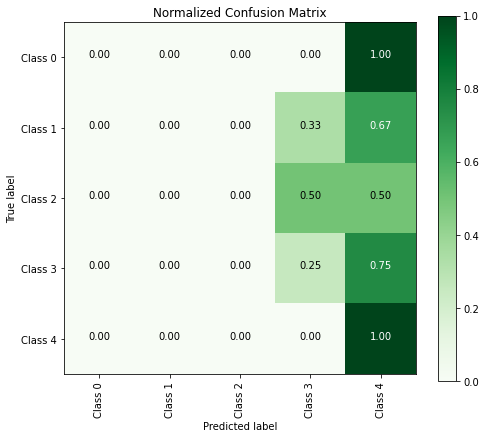

In [209]:
go(DTL, NTL)